## Model evaluation

In [1]:
using Flux
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [2]:
using Revise
using TokenizersLite
using TransformersLite

In [3]:
includet("reporting.jl")
includet("training.jl")

In [4]:
nlabels = 5

5

## Load data

raw

In [5]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [6]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [7]:
nrow(df)

200000

In [8]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [9]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


## Tokenizers

In [10]:
vocab_directory = "..\\vocab\\bpe"
path_rules = joinpath(vocab_directory, "amazon_reviews_train_en_rules.txt")
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)
max_length = 50

@show tokenizer = load_bpe(path_rules, startsym="⋅")
#@show tokenizer = load_affix_tokenizer(path_vocab)
@show indexer = IndexTokenizer(vocab, "[UNK]")

tokenizer = load_bpe(path_rules, startsym = "⋅") = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer(vocab, "[UNK]") = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

In [11]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document, tokenizer; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

preprocess (generic function with 1 method)

In [12]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:5) # multi-class
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 41.406462 seconds (654.73 M allocations: 20.558 GiB, 9.31% gc time, 1.31% compilation time)
 16.542615 seconds (114.70 k allocations: 83.864 MiB, 0.16% gc time, 0.37% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [13]:
y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.652828 seconds (6.00 M allocations: 210.075 MiB, 5.88% gc time, 15.54% compilation time)
  0.427662 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


## Evaluate

In [14]:
loss(x, y) = Flux.logitcrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])
accuracy(ŷ, y) = mean(Flux.onecold(ŷ) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [15]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x) 

add_position_encoding (generic function with 1 method)

In [16]:
directory = "../outputs/20220519_1507"

BSON.@load joinpath(directory, "model.bson") model
model

TransformerClassifier(
     Embed((32, 7455)),                 # 238_560 parameters
     PositionEncoding(32),
     Dropout(0.1),
     TransformerEncoderBlock(
          MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
               denseQ = Dense(32 => 32),  # 1_056 parameters
               denseK = Dense(32 => 32),  # 1_056 parameters
               denseV = Dense(32 => 32),  # 1_056 parameters
               denseO = Dense(32 => 32),  # 1_056 parameters
          )
          Dropout(0.1),
          LayerNorm(32),                # 64 parameters
          Dense(32 => 128, relu),       # 4_224 parameters
          Dense(128 => 32),             # 4_128 parameters
          Dropout(0.1),
          LayerNorm(32),                # 64 parameters
     )
     Dense(32 => 1),                    # 33 parameters
     FlattenLayer(),
     Dense(50 => 5),                    # 255 parameters
)                  # Total: 21 arrays, 251_552 parameters, 1.083 MiB.

In [17]:
@time batched_metric(accuracy, train_data[1], train_data[2], g=model)

 64.631376 seconds (36.73 M allocations: 56.873 GiB, 9.09% gc time, 21.04% compilation time)


0.5418555555555532

In [18]:
@time batched_metric(accuracy, val_data[1], val_data[2], g=model)

  5.001310 seconds (31.56 k allocations: 6.106 GiB, 9.00% gc time)


0.5127499999999999

In [19]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[1.2605, 1.17919, 1.13757, 1.11599, 1.09812, 1.08565, 1.07…
  "train_acc"  => Any[0.437611, 0.477711, 0.499644, 0.509317, 0.518028, 0.52563…
  "val_acc"    => Any[0.42995, 0.4732, 0.4869, 0.4932, 0.5048, 0.5086, 0.50875,…
  "val_loss"   => Any[1.26911, 1.19716, 1.16267, 1.14799, 1.13512, 1.13143, 1.1…

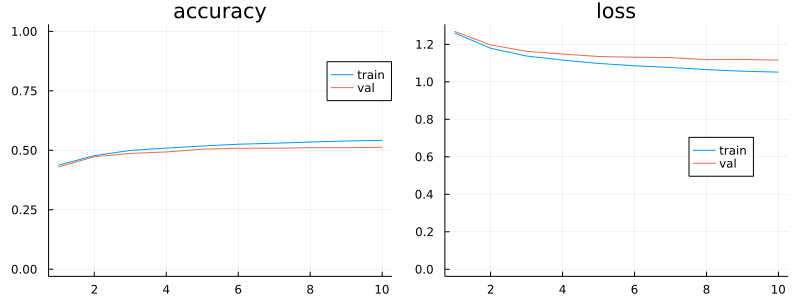

In [20]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))
plot(p1, p2, layout=grid(1, 2), size=(800, 300))

## Test data

In [21]:
logits = model(X_test)
accuracy(logits, y_test)

0.499

In [22]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [23]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 687  232   46    8   27
 271  435  209   50   35
 144  305  299  194   58
  26   98  238  342  296
  26   37   42  163  732

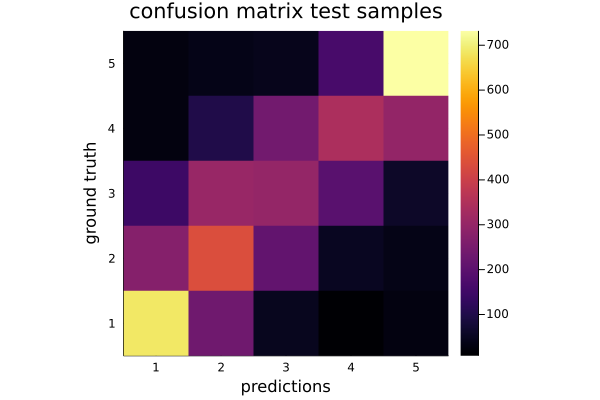

In [24]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
#savefig(p, "../outputs/confusion_matrix_classification$(nlabels).png")
p

In [25]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.60    0.69      0.64     1000
           2       0.39    0.43      0.41     1000
           3       0.36    0.30      0.33     1000
           4       0.45    0.34      0.39     1000
           5       0.64    0.73      0.68     1000

weighted avg       0.49    0.50      0.49     5000

In [26]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    println(" idx  y  ŷ ")
    for idx in sample(idxs_wrong, nshow, replace=false)
        @printf("%4d  %d  %d  %s\n\n",
            idx, labels_test[idx], y_pred[idx], documents_test[idx]
        )
    end
end


true label = 1
#incorrect 313
 idx  y  ŷ 
 416  1  3  Kind of lame. Thought it would be a hat that I could have worn for our Mexican themed party. But it was just a little floatie thing with no hole for your head. So now it will just have to be our life saving pool device.

 826  1  5  Had Western Digital in all my builds and they've been great. Decided to try the Fire Cuda and it failed two weeks in and I lost so much data. Never again!!


true label = 2
#incorrect 565
 idx  y  ŷ 
1686  2  1  Firstly don't believe the rating here. Fakespot.com gives it a ranking of D, which means it is very likely that there are a lot of fake good reviews here. Pro: The robot is a new category of toy, or you can even call it a pet. It go explore by itself and it does not require a phone to do so. It wakes up in the morning and wanders around and makes cute noise. It greets you when you get home (you have to make sure that he hears you and sees your face though). In summary, being autonomous is a majo

## Probabilities for all labels

In [27]:
println("star  y  ŷ   prob")
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    @printf("   %1d  %d  %d  %.4f  %s\n\n",
            star, labels_test[pos_max], y_pred[pos_max], probs[star, pos_max], documents_test[pos_max]
        )
end

star  y  ŷ   prob
   5  5  5  0.9776  Best purchase I have ever made!!! This mirror is amazing! I highly recommend this product super sturdy, lighting is perfect, super cute and easy to use! I’m recommending this to all my co workers! I’m honestly thinking about buying a second one for myself and a couple for Christmas gifts (:

   4  4  4  0.8548  Great product. Only complaint I have was in packaging some paints did leak. Otherwise excellent!

   3  3  3  0.6778  Maybe I’m not that good at applying it. But it seems really hard to get on without streaks, and it only seems to work okay

   2  3  2  0.6207  I love the look of this necklace. After wearing it for 24 hours, the chain broke where the locking clasp is attached. Very disappointed with the chain.

   1  1  1  0.9877  Totally got scammed. Worked for 10min. Thanks



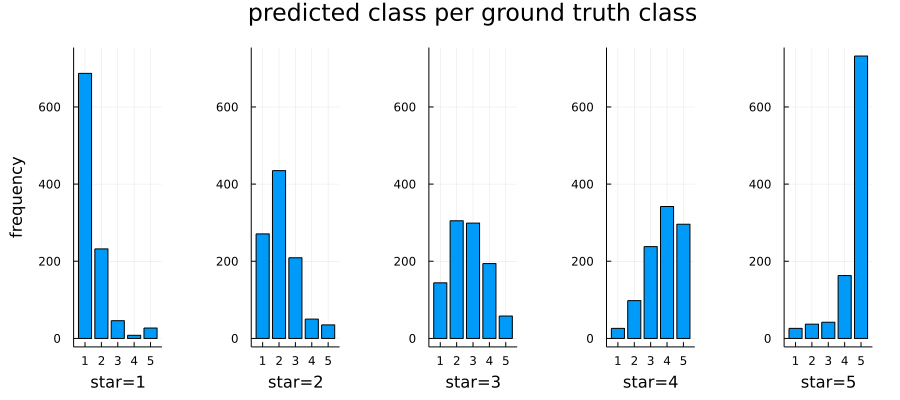

In [28]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
#savefig(p, "../outputs/predictions_classification$nlabels.png")
p

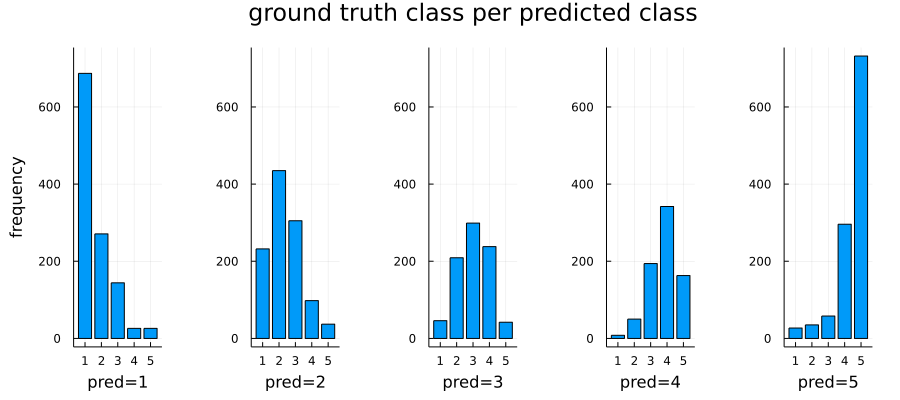

In [29]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="pred=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
#savefig(p, "../outputs/predictions_classification$nlabels.png")
p

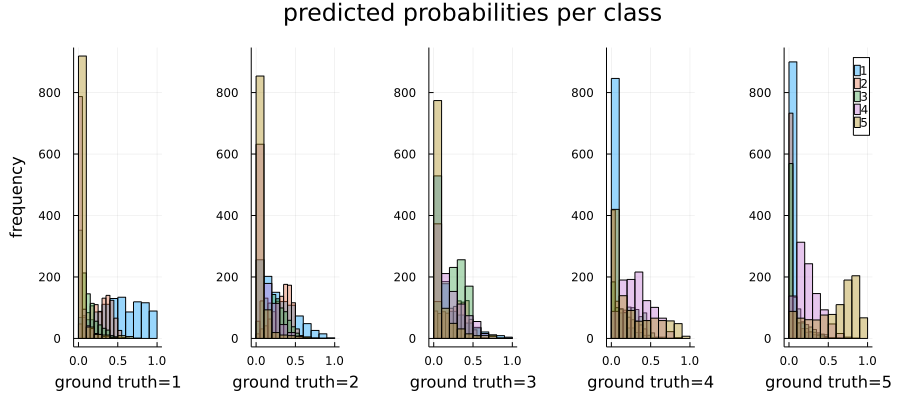

In [30]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted probabilities per class",
    margin=5Plots.mm)
#savefig(p, "outputs/probabilities_classification$nlabels.png")
p

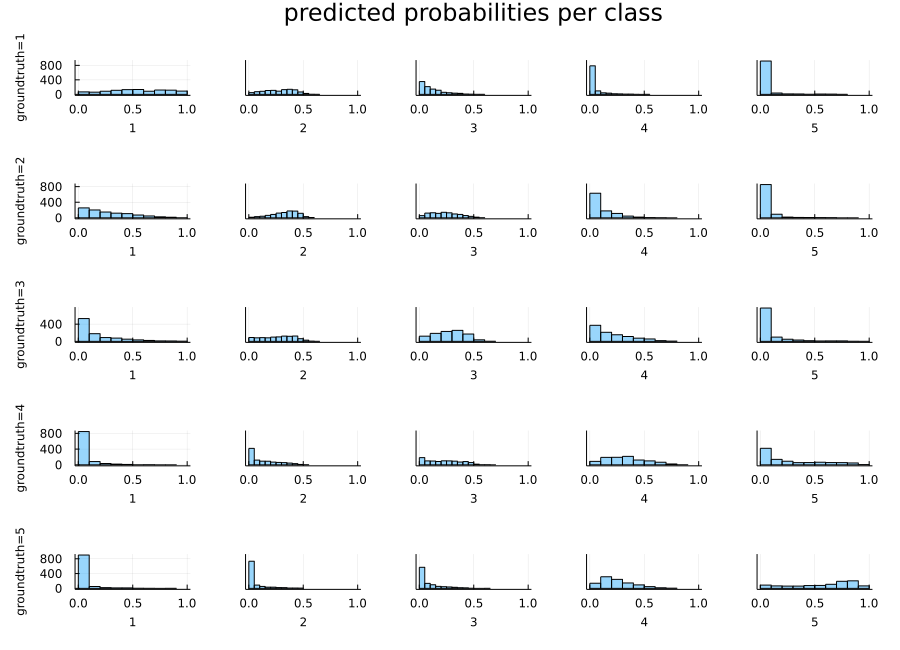

In [31]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
#plot!(canvases[1], ylabel="frequency")
#plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="predicted probabilities per class",
    margin=5Plots.mm)
#savefig(p, "outputs/probabilities_classification$nlabels.png")
p

## Single sample

In [38]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !
⋅used|⋅for|⋅party|⋅and|⋅was|⋅great
89|7|805|4|14|29|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [39]:
model.embed(x)

32×50 Matrix{Float32}:
 -0.185498    0.308839   1.26867    …  -0.74563    -0.74563    -0.74563
 -1.60428    -0.214309   1.96342       -0.30108    -0.30108    -0.30108
  0.0864683   0.124096  -0.315187       0.893248    0.893248    0.893248
 -0.420657   -0.385402  -0.312947      -1.50554    -1.50554    -1.50554
  0.772221    0.340003  -0.380047       0.155356    0.155356    0.155356
  0.970418   -0.32687    2.20437    …  -0.460243   -0.460243   -0.460243
  0.761756    0.605889   0.563619      -0.459859   -0.459859   -0.459859
  1.4059     -1.05189   -1.43491       -0.144123   -0.144123   -0.144123
 -1.56437    -0.968979  -0.744929       0.468587    0.468587    0.468587
 -0.733349   -0.988166  -0.391337       0.611758    0.611758    0.611758
  0.221584   -0.882952   0.0900595  …   0.0625451   0.0625451   0.0625451
  0.104657   -0.405627  -0.860591      -0.978644   -0.978644   -0.978644
  0.496195    0.451909   2.18153        0.512873    0.512873    0.512873
  ⋮                           

In [40]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.0020574492
 0.004077889
 0.017180908
 0.18931532
 0.7873685